# Controller - PID

Reference:

Lecture 8 - Control I [ [PDF](https://www.ic.unicamp.br/~esther/teaching/2019s2/mo651/Lecture%2008%20-%20ControlI.pdf) ]

In [2]:
using VREPRobot
using Plots
using StatsPlots
using Images
pyplot()

Plots.PyPlotBackend()

In [3]:
robot = Robot()

Connected to remoteApi server.
Pioneer_p3dx_ultrasonicSensor1 connected.
Pioneer_p3dx_ultrasonicSensor2 connected.
Pioneer_p3dx_ultrasonicSensor3 connected.
Pioneer_p3dx_ultrasonicSensor4 connected.
Pioneer_p3dx_ultrasonicSensor5 connected.
Pioneer_p3dx_ultrasonicSensor6 connected.
Pioneer_p3dx_ultrasonicSensor7 connected.
Pioneer_p3dx_ultrasonicSensor8 connected.
Pioneer_p3dx_ultrasonicSensor9 connected.
Pioneer_p3dx_ultrasonicSensor10 connected.
Pioneer_p3dx_ultrasonicSensor11 connected.
Pioneer_p3dx_ultrasonicSensor12 connected.
Pioneer_p3dx_ultrasonicSensor13 connected.
Pioneer_p3dx_ultrasonicSensor14 connected.
Pioneer_p3dx_ultrasonicSensor15 connected.
Pioneer_p3dx_ultrasonicSensor16 connected.
Laser connected.
Vision sensor connected.
Left motor connected.
Right motor connected.
Robot connected.


Robot(0, Int32[328, 327, 326, 325, 324, 323, 322, 321, 336, 335, 334, 333, 332, 331, 330, 329], 348, 355, Dict(:left => 311,:right => 308), 307, 0.381f0, 0.0975f0)

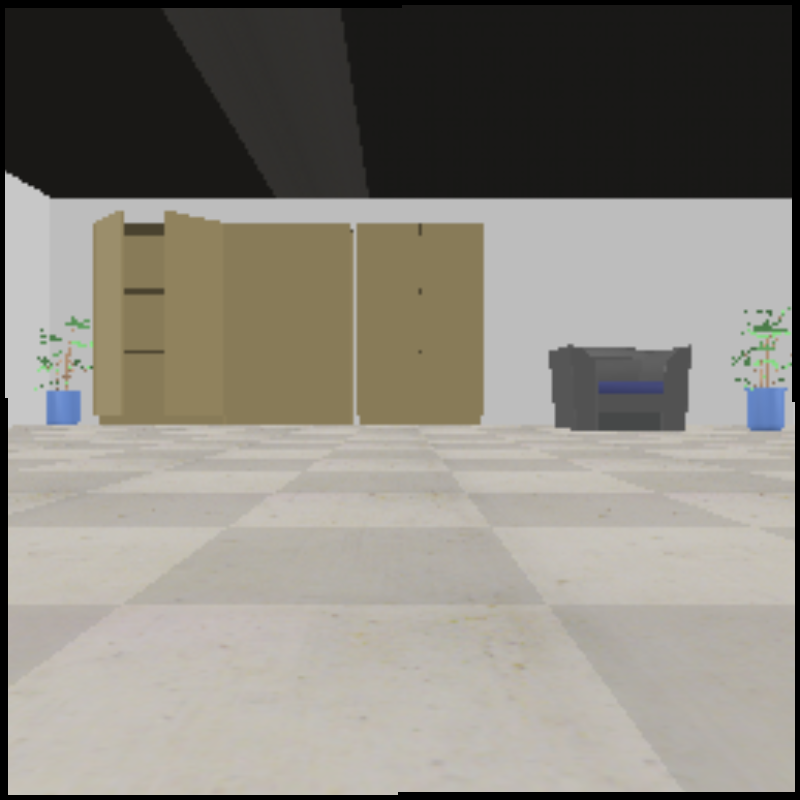

In [4]:
function show_vision(robot; size=(800, 800))
    resolution, image_data = read_vision(robot)
    image = imrotate(colorview(RGB, reshape(Float64.(image_data) / 255, 3, Int64.(resolution)...)), 3π/2)
    image = imresize(image, size...)
    return image
end

show_vision(robot)